# Experiment Analysis

This notebook is used to analyze the results of certain experiments which can be found in the pycomex experiment archive located at the ``RESULTS_PATH`` directory.

In [80]:
import os
import time
import json
import datetime
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from rich.pretty import pprint
from pycomex.utils import is_experiment_archive
from pycomex.utils import render_string_table
from pycomex.functional.experiment import Experiment

# This will be the path to the directory in which the notebook is located.
PATH: str = os.getcwd()
# This will have to be the path to the pycomex "results" directory containing the 
# experiment archives of interest.
# HAS TO BE CHANGED, if the analysis is not located in the same directory as the results
# folder.
RESULTS_PATH: str = os.path.join(PATH, 'results')

In [81]:
import datetime


# Filter which experiments will be loaded based on their name and/or parameters.
def select_experiment(experiment_name: str,
                      experiment_metadata: dict,
                      experiment_parameters: dict,
                      ) -> bool:
    main_condition = '__PREFIX__' in experiment_parameters and 'ex_04_ah' in experiment_parameters['__PREFIX__']
    
    end_time: float = experiment_metadata['end_time']
    end_datetime = datetime.datetime.fromtimestamp(end_time)
    now = datetime.datetime.now()
    max_delta = datetime.timedelta(weeks=2)
    date_condition = (now - end_datetime) <= max_delta

    return main_condition and date_condition


# Assign a unique key to the experiment based on its data / parameters etc.
# Later on the experiments will be sorted based on this key which will be the 
# key of a dictionary and the values will be a list of all the experiments with 
# that same key.
def sort_experiment(experiment: Experiment) -> tuple:
    *_, encoding, dataset = experiment.metadata['name'].split('__')
    
    if '_fp' in experiment.metadata['name']:
        encoding = 'fp'
    elif '_hdc' in experiment.metadata['name']:
        encoding = 'hdc'
    elif '_gnn' in experiment.metadata['name']:
        encoding = 'gnn'
    
    method = experiment.parameters['MODELS'][0]
    num_train = experiment.parameters['NUM_TRAIN']
    
    return (encoding, method, num_train)

### Experiment Discovery

The following cell will first discover all of the previously executed experiment runs which have been archived in the given results directory. It will then print the number of experiments found.

In [82]:
# This list will contain the paths to the individual expeirment *namespaces* which in 
# turn contain the actual individual experiment archives.
experiment_namespace_paths: list[str] = [
    path
    for file_name in os.listdir(RESULTS_PATH)
    if os.path.isdir(path := os.path.join(RESULTS_PATH, file_name))
]

# Subsequently, this list will contain the paths to the individual experiment archives
# folders.
experiment_paths: list[str] = []
for namespace_path in experiment_namespace_paths:
    for dirpath, dirnames, filenames in os.walk(namespace_path):
        if is_experiment_archive(dirpath):
            experiment_paths.append(dirpath)
            dirnames.clear() # Prevents further recursion into subdirectories
        
print(f'✅ found {len(experiment_paths)} experiment archives in {len(experiment_namespace_paths)} namespaces')
pprint(experiment_paths, max_length=3)

✅ found 33657 experiment archives in 38 namespaces


[
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_29__6zGY',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/debug',
│   '/media/ssd2/Programming/graph_hdc/graph_hdc/experiments/fingerprints/results/predict_molecules__hdc__bace/ex_01_a__10_01_2025__18_32__Sozn',
│   ... +33654
]

### Experiment Loading

The following cell will then load the experiment runs into memory selectively based on the previously defined ``select_experiment`` function. Only experiments for which the function returns ``True`` will be loaded into memory. The loaded experiments will actually be restored from the archive by loading the parameters as well as the data back into a ``pycomex.experiment.Experiment`` object.

In [83]:
# This list will be populated with the actual Experiment instances which will 
# be loaded from the experiment archive folders.
experiments: list[Experiment] = []

print('Loading experiments from archives...')
time_start: float = time.time()
for experiment_path in experiment_paths:
    
    experiment_identifier: str = os.path.basename(experiment_path)
    
    experiment_data_path = os.path.join(experiment_path, Experiment.DATA_FILE_NAME)
    if not os.path.exists(experiment_data_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no data found')
        continue
    
    experiment_meta_path = os.path.join(experiment_path, Experiment.METADATA_FILE_NAME)
    if not os.path.exists(experiment_meta_path):
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no metadata found')
        continue
    
    with open(experiment_meta_path) as file:
        content = file.read()
        # This will contain the experiment metadata as a dictionary which we can now use to
        # filter for instance.
        experiment_metadata: dict = json.loads(content)
        
    if 'parameters' not in experiment_metadata:
        print(f'   ⚠️ Skipping experiment "{experiment_identifier}" - no parameters found')
        continue
    
    experiment_parameters: dict = {
        param: info['value']
        for param, info in experiment_metadata['parameters'].items()
        if 'value' in info
    }
    
    # Here we apply the filter to determine whether or not the experiment should be included
    # in the analysis.
    condition: bool = select_experiment(
        experiment_name=experiment_metadata['name'],
        experiment_metadata=experiment_metadata,
        experiment_parameters=experiment_parameters
    )
    
    if condition:
        try:
            print(f'   > included experiment "{experiment_identifier}"')
            experiment: Experiment = Experiment.load(experiment_path)
            experiments.append(experiment)
        except Exception as e:
            print(f'   ⚠️ Failed to load experiment "{experiment_identifier}" - Exception: {e}')
            
time_end: float = time.time()
duration: float = time_end - time_start
print(f'✅ Loaded {len(experiments)} experiments in {duration:.2f} seconds')

Loading experiments from archives...
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_00_c__17_08_2025__16_08__JXbr" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_e__15_01_2025__09_00__MnVH" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "debug" - no data found
   ⚠️ Skipping experiment "ex_04_ad__11_09_2025__20_43__hJiq" - no data found
   ⚠️ Skipping experiment "ex_04_d__06_08_2025__13_15__ja1g" - no data found
   ⚠️ Skipping experiment "hyperopt_b__16_01_2025__08_56__Cv1n" - no data found
   > included experiment "ex_04_ah__03_10_2025__22_48__ZIqc"
   ⚠️ Skipping experiment "ex_03_b__31_07_2025__11_49__M1Nv" - no data found
   > included experiment "ex_04_ah__03_10_2025__21_20__Bwoz"
   > included experiment "ex_04_ah__03_10_2025__12_38__h0ba"
   > included experiment "ex_04_ah__03_10_2025__12_17__bPCO"
   

In [84]:
example_experiment: Experiment = experiments[0] if experiments else None
pprint(example_experiment.data, max_length=10)

{
│   'indices': {
│   │   'train': [18706, 86891, 71166, 54173, 94678, 102945, 27616, 60828, 5902, 67653, ... +2490],
│   │   'val': [55605, 24939, 128842, 17661, 12654, 92341, 2191, 7667, 128317, 73813, ... +12039],
│   │   'test': [60803, 116649, 96413, 83340, 105212, 47224, 9294, 30076, 9749, 125250, ... +13378]
│   },
│   'metrics': {
│   │   'test_k_neighbors': {'r2': 0.643203550043433, 'mse': 0.0007984287296982374, 'mae': 0.021517491783686886}
│   }
}

### Experiment Sorting

The following cell will sort the - currently still unsorted - experiment list by a custom criteria defined in the ``sort_experiments`` function. This is done by putting all the experiments into the same list for which this function returns the same index tuple. The result is the ``key_experiment_map`` dictionary data structure which maps the index tuple to a list of experiments.

In [85]:
# This will be a dictionary mapping the unique key of the experiment to a list of
# experiments which share that key. This will allow us to group experiments based on
# their parameters or other attributes.
key_experiment_map: dict[tuple, list[Experiment]] = defaultdict(list)

for experiment in experiments:
    key: tuple = sort_experiment(experiment)
    key_experiment_map[key].append(experiment)
    
key_experiment_map = dict(sorted(key_experiment_map.items(), key=lambda item: item[0][0] + item[0][1] + f'{int(item[0][2]):06d}'))
pprint(key_experiment_map, max_length=3)

{
│   ('fp', 'k_neighbors', 10): [
│   │   <pycomex.functional.experiment.Experiment object at 0x761e37f83550>,
│   │   <pycomex.functional.experiment.Experiment object at 0x761e3726c190>,
│   │   <pycomex.functional.experiment.Experiment object at 0x761e36edaed0>,
│   │   ... +2
│   ],
│   ('fp', 'k_neighbors', 50): [
│   │   <pycomex.functional.experiment.Experiment object at 0x761e37289610>,
│   │   <pycomex.functional.experiment.Experiment object at 0x761e33ebb490>,
│   │   <pycomex.functional.experiment.Experiment object at 0x761e32840990>,
│   │   ... +2
│   ],
│   ('fp', 'k_neighbors', 100): [
│   │   <pycomex.functional.experiment.Experiment object at 0x761e3818a350>,
│   │   <pycomex.functional.experiment.Experiment object at 0x761e37815150>,
│   │   <pycomex.functional.experiment.Experiment object at 0x761e374911d0>,
│   │   ... +2
│   ],
│   ... +62
}

### Experiment Result Table

The following cell illustrates how to create a table from the aggregated results of many loaded experiments, which is a common use case of the analysis.

In [86]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Encoding', 'Method', 'Num Train', 'Result']

# This data structure will hold the (encoding, dataset, method) tuple as keys and the metric
# values as a list value.
key_values_map = defaultdict(list)

for (encoding, method, num_train), _experiments in key_experiment_map.items():
    
    example_experiment = _experiments[0]
    if example_experiment.parameters['DATASET_TYPE'] == 'regression':
        metric = 'mae'
    else:
        metric = 'f1'
        
    values = [exp.data['metrics'][f'test_{method}'][metric] for exp in _experiments if 'metrics' in exp.data]
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    table.add_row([
        encoding,
        method,
        num_train,
        f'{mean_value:.2f} ± {std_value:.2f}',
    ])
    
    key_values_map[(encoding, method, num_train)] = values
    
print(table.get_string())

+----------+-------------+-----------+-------------+
| Encoding |    Method   | Num Train |    Result   |
+----------+-------------+-----------+-------------+
|    fp    | k_neighbors |     10    | 0.04 ± 0.00 |
|    fp    | k_neighbors |     50    | 0.03 ± 0.00 |
|    fp    | k_neighbors |    100    | 0.03 ± 0.00 |
|    fp    | k_neighbors |    250    | 0.03 ± 0.00 |
|    fp    | k_neighbors |    500    | 0.03 ± 0.00 |
|    fp    | k_neighbors |    1000   | 0.03 ± 0.00 |
|    fp    | k_neighbors |    2500   | 0.03 ± 0.01 |
|    fp    | k_neighbors |    5000   | 0.03 ± 0.00 |
|    fp    | k_neighbors |    7500   | 0.02 ± 0.00 |
|    fp    | k_neighbors |   10000   | 0.02 ± 0.00 |
|    fp    | k_neighbors |   25000   | 0.02 ± 0.00 |
|    fp    | k_neighbors |   50000   | 0.01 ± 0.00 |
|    fp    | k_neighbors |   100000  | 0.01 ± 0.00 |
|    fp    |  neural_net |     10    | 0.04 ± 0.00 |
|    fp    |  neural_net |     50    | 0.03 ± 0.00 |
|    fp    |  neural_net |    100    | 0.03 ± 

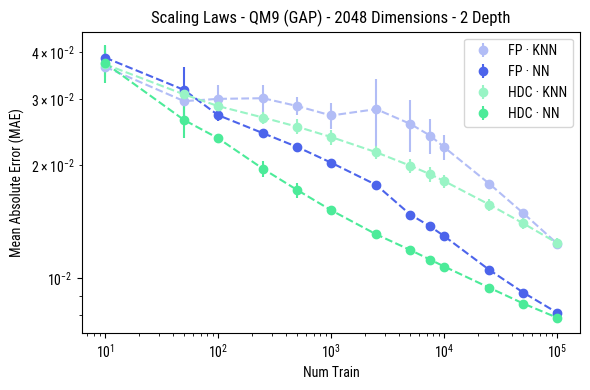

In [87]:
"""
Visualization: Scaling Laws Analysis

This cell creates a log-log plot showing how model performance scales with training set size
for different encoding methods (Fingerprints, GNN, HDC) and prediction models (Neural Net, etc.).
The plot helps identify which methods are most data-efficient and how they compare at different
training set sizes.
"""

# ============================================================================
# CONFIGURATION
# ============================================================================

# Exclude specific (encoding, method) combinations from the visualization
# This is useful for focusing on the most relevant methods or removing underperforming approaches
EXCLUDE_METHODS: list[tuple] = [
    # ('fp', 'k_neighbors'),      # Fingerprint k-NN baseline (less relevant for scaling analysis)
    # ('hdc', 'k_neighbors'),     # HDC k-NN baseline (less relevant for scaling analysis)
    ('fp', 'random_forest'),    # Fingerprint Random Forest
    ('hdc', 'random_forest'),   # HDC Random Forest
    ('gnn', 'gatv2')
]


# ============================================================================
# IMPORTS AND PLOT SETUP
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Apply default matplotlib style
plt.style.use('default')

# Use Roboto Condensed font for consistent typography
plt.rcParams['font.family'] = 'Roboto Condensed'

# Create figure with appropriate size for publication/presentation
plt.figure(figsize=(6, 4))


# ============================================================================
# VISUAL MAPPINGS: LABELS AND COLORS
# ============================================================================

# Human-readable labels for each (encoding, method) combination
# These labels will appear in the plot legend
key_label_map = defaultdict(lambda: 'Unknown Method')
key_label_map.update({
    ('fp', 'neural_net'): 'FP · NN',          # Fingerprint with Neural Network
    ('fp', 'neural_net2'): 'FP · NN',         # Alternative NN configuration
    ('fp', 'random_forest'): 'FP · RF',       # Fingerprint with Random Forest
    ('fp', 'k_neighbors'): 'FP · KNN',        # Fingerprint with k-NN
    ('gnn', 'gatv2'): 'GNN · GATv2',          # Graph Attention Network v2
    ('hdc', 'neural_net'): 'HDC · NN',        # Hyperdimensional Computing with NN
    ('hdc', 'neural_net2'): 'HDC · NN',       # Alternative HDC NN configuration
    ('hdc', 'random_forest'): 'HDC · RF',     # HDC with Random Forest
    ('hdc', 'k_neighbors'): 'HDC · KNN',    
})

# Color scheme for different encoding-method combinations
# Blue shades for Fingerprint methods
# Orange shades for GNN methods
# Green shades for HDC methods
key_color_map = defaultdict(lambda: '#000000')  # Default black if not specified
key_color_map.update({
    ('fp', 'neural_net'): '#4C64EB',          # Deep blue for FP+NN
    ('fp', 'neural_net2'): '#4C64EB',         
    ('fp', 'random_forest'): '#B2BDF6',       # Light blue for FP+RF
    ('fp', 'k_neighbors'): '#B2BDF6',       # Light blue for FP+RF
    ('gnn', 'gatv2'): '#EBA14C',              # Orange for GNN
    ('gnn', 'gin'): '#EBA14C',                # Orange for GNN variants
    ('hdc', 'neural_net'): '#4CEB99',         # Teal/green for HDC+NN
    ('hdc', 'neural_net2'): '#4CEB99', 
    ('hdc', 'random_forest'): '#99F4C5',      # Light green for HDC+RF
    ('hdc', 'k_neighbors'): '#99F4C5',      # Light green for HDC+RF
})


# ============================================================================
# DATA PREPARATION
# ============================================================================

# Group experiments by (encoding, method), collecting all num_train values and their results
# This transforms the flat key_values_map into a hierarchical structure suitable for line plots
grouped = defaultdict(list)
for (encoding, method, num_train), vals in key_values_map.items():
    grouped[(encoding, method)].append((num_train, vals))


# ============================================================================
# PLOTTING: ERROR BARS AND TREND LINES
# ============================================================================

for (encoding, method), items in grouped.items():
    # Skip excluded method combinations
    if (encoding, method) in EXCLUDE_METHODS:
        continue
    
    # Sort data points by training set size for proper line plotting
    items = sorted(items, key=lambda x: x[0])
    
    # Extract x-values (training set sizes), means, and standard deviations
    num_trains = np.array([num_train for num_train, _ in items])
    means = np.array([np.mean(vals) for _, vals in items])
    stds = np.array([np.std(vals) for _, vals in items])

    # Get human-readable label and color for this method
    label = key_label_map[(encoding, method)]
    color = key_color_map[(encoding, method)]
    
    # Plot error bars showing mean ± std for each training set size
    plt.errorbar(num_trains, means, yerr=stds, fmt='o', label=label, color=color)

    # Connect points with dashed lines to show the scaling trend
    plt.plot(num_trains, means, color=color, linestyle='--')


# ============================================================================
# METADATA EXTRACTION
# ============================================================================

# Extract experiment configuration details from a representative experiment
# This information is used for the plot title
import random
example_experiment = next(e for e in experiments if e.parameters.get('FINGERPRINT_SIZE'))

# Get embedding/fingerprint dimensionality
if 'FINGERPRINT_SIZE' in example_experiment.parameters:
    embedding_size = example_experiment.parameters['FINGERPRINT_SIZE']
else:
    embedding_size = example_experiment.parameters.get('EMBEDDING_SIZE', 'unknown')

# Get dataset name
dataset_name = example_experiment.parameters.get('DATASET_NAME', 'unknown')
    
# Human-readable dataset names
dataset_label_map = {
    'qm9_energy': 'QM9 ($U_0$)',   
    'qm9_smiles': 'QM9 (GAP)',
    'aqsoldb': 'AqSolDB',
    'zinc250k': 'ZINC250k (ClogP)',
    'ames': 'Mutagenicity',
}

# Human-readable metric names
metric_label_map = {
    'mae': 'Mean Absolute Error (MAE)',
    'mse': 'Mean Squared Error (MSE)',
    'r2': 'R² Score',
    'f1': 'F1 Score',
    'ap': 'Average Precision (AP)',
    'log_loss': 'Cross Entropy Loss',
}


# ============================================================================
# AXIS CONFIGURATION AND DISPLAY
# ============================================================================

# Use log-log scale to visualize power-law scaling relationships
# This makes it easier to identify if methods follow predictable scaling laws
plt.xscale('log')
plt.yscale('log')

# Set axis labels
plt.xlabel('Num Train')
plt.ylabel(metric_label_map.get(metric, metric))

# Create informative title with experiment details
plt.title(f'Scaling Laws - {dataset_label_map[dataset_name]} - {embedding_size} Dimensions - 2 Depth')

# Add legend to distinguish different methods
plt.legend()

# Optimize layout to prevent label clipping
plt.tight_layout()

# Display the plot
plt.show()
